In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from shapely.geometry import shape, Point


### Map of emission for 2016 (test)

In [7]:
# The color corresponding to each substance
substance_colors = {
    "Heptachlor": "red",
    "Indeno(1,2,3-cd)pyrene": "orange",
    "Benzo(g,h,i)perylene": "green",
    "Cypermethrin": "blue",
    "Fluoranthene": "purple",
}

target_substances = list(substance_colors.keys())
region_name = "South West"
geojson_path = "Regions.geojson"

# Load the geographical boundary
with open(geojson_path, "r", encoding="utf-8") as f:
    geojson_data = json.load(f)

selected_region = next(
    (f for f in geojson_data["features"] if f["properties"].get("RGN24NM") == region_name), None
)
if not selected_region:
    raise ValueError(f"Region '{region_name}' not found in GeoJSON")

geom = shape(selected_region["geometry"])

# drawing function
def plot_map(csv_file, year):
    # Load the data 
    df = pd.read_csv(csv_file)
    df.columns = df.columns.str.strip()
    df["SUBSTANCE NAME"] = df["SUBSTANCE NAME"].str.strip()

    # Screen the target pollutants, ensure coordinates/thresholds/emissions are not empty
    df = df[
        df["SUBSTANCE NAME"].isin(target_substances) &
        df["Latitude"].notna() &
        df["Longitude"].notna() &
        df["REPORTING THRESHOLD (kg)"].notna() &
        df["QUANTITY RELEASED (kg)"].notna()
    ].copy()

    # Determine whether it exceeds the threshold
    def is_over_threshold_and_in_region(row):
        try:
            qty = float(row["QUANTITY RELEASED (kg)"])
            threshold = float(row["REPORTING THRESHOLD (kg)"])
            point = Point(float(row["Longitude"]), float(row["Latitude"]))
            return qty > threshold and geom.contains(point)
        except:
            return False

    df_filtered = df[df.apply(is_over_threshold_and_in_region, axis=1)]

    # Generate plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # boundary
    if geom.geom_type == "Polygon":
        x, y = geom.exterior.xy
        ax.fill(x, y, color="lightblue", edgecolor="black", alpha=0.7)
    elif geom.geom_type == "MultiPolygon":
        for polygon in geom.geoms:
            x, y = polygon.exterior.xy
            ax.fill(x, y, color="lightblue", edgecolor="black", alpha=0.7)

    ax.set_title(f"{year} South West - Over Threshold Emissions", fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

    # Draw pollutant points
    for _, row in df_filtered.iterrows():
        substance = row["SUBSTANCE NAME"]
        color = substance_colors.get(substance, "gray")
        ax.scatter(
            float(row["Longitude"]),
            float(row["Latitude"]),
            marker="o",
            color=color,
            s=100,
            edgecolor="black"
        )

    # Add legend (based on color)
    legend_handles = [
        plt.Line2D([], [], marker="o", color=color, label=substance, linestyle="None", markersize=10)
        for substance, color in substance_colors.items()
    ]
    ax.legend(handles=legend_handles, title="Substances", loc="lower left")

    # save the plots
    output_path = f"{year}_south_west_emissions_map.png"
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"✅ Saved: {output_path}")

# Generate maps of the three years
plot_map("Datasets/d16_v3.csv", 2016)
plot_map("Datasets/d19_v3.csv", 2019)
plot_map("Datasets/d23_v3.csv", 2023)


✅ Saved: 2016_south_west_emissions_map.png
✅ Saved: 2019_south_west_emissions_map.png
✅ Saved: 2023_south_west_emissions_map.png


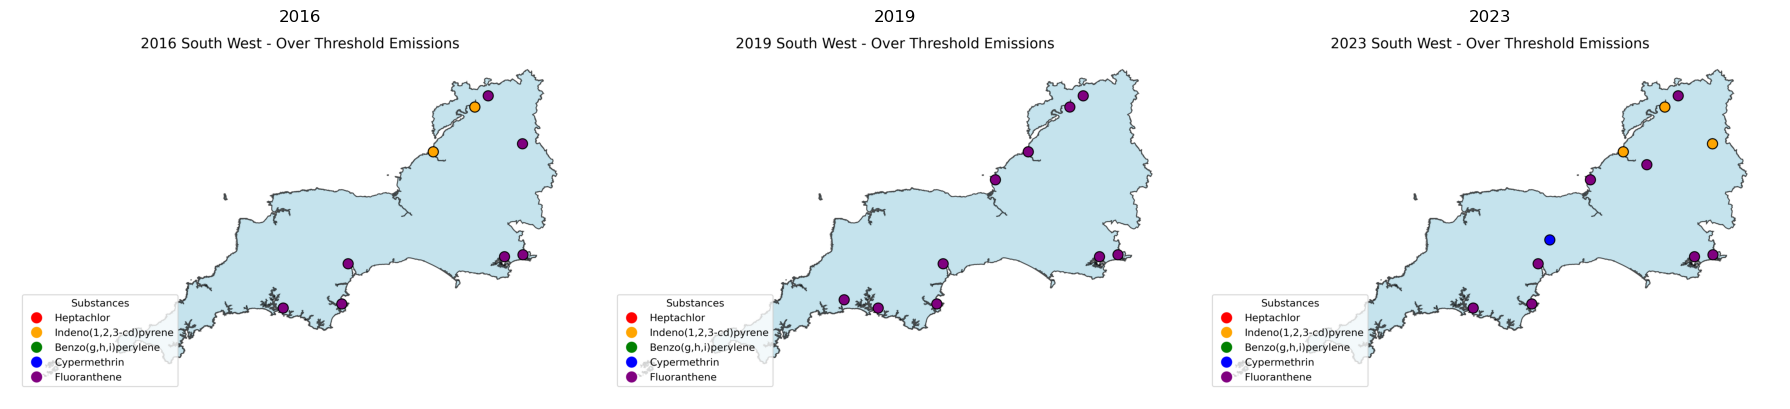

In [14]:
from PIL import Image
import matplotlib.pyplot as plt

img_2016 = Image.open("2016_south_west_emissions_map.png")
img_2019 = Image.open("2019_south_west_emissions_map.png")
img_2023 = Image.open("2023_south_west_emissions_map.png")

# Display the maps
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  

for ax, img, year in zip(axs, [img_2016, img_2019, img_2023], [2016, 2019, 2023]):
    ax.imshow(img)
    ax.set_title(f"{year}")
    ax.axis("off") 

plt.tight_layout()
plt.show()

### Emission maps (full version)

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from shapely.geometry import shape, Point

# The color corresponding to each substance
substance_colors = {
    "Heptachlor": "red",
    "Indeno(1,2,3-cd)pyrene": "orange",
    "Benzo(g,h,i)perylene": "green",
    "Cypermethrin": "blue",
    "Fluoranthene": "purple",
}

target_substances = list(substance_colors.keys())

# Regions list
regions_to_plot = [
    "South West",
    "North East",
    "North West",
    "Yorkshire and The Humber",
    "East Midlands",
    "West Midlands",
    "East of England",
    "London",
    "South East"
]

# GeoJSON path
geojson_path = "Regions.geojson"

# read geojson file
with open(geojson_path, "r", encoding="utf-8") as f:
    geojson_data = json.load(f)

def plot_region_map(csv_file, year, region_name):
    # get the region boundary
    selected_region = next(
        (f for f in geojson_data["features"] if f["properties"].get("RGN24NM") == region_name), None
    )
    if not selected_region:
        print(f" Region '{region_name}' not found in GeoJSON")
        return

    geom = shape(selected_region["geometry"])

    # read the data
    df = pd.read_csv(csv_file)
    df.columns = df.columns.str.strip()
    df["SUBSTANCE NAME"] = df["SUBSTANCE NAME"].str.strip()

    # screen the target substance and valid data
    df = df[
        df["SUBSTANCE NAME"].isin(target_substances) &
        df["Latitude"].notna() &
        df["Longitude"].notna() &
        df["REPORTING THRESHOLD (kg)"].notna() &
        df["QUANTITY RELEASED (kg)"].notna()
    ].copy()

    # screen the points that over the threshold and in the region
    def is_over_threshold_and_in_region(row):
        try:
            qty = float(row["QUANTITY RELEASED (kg)"])
            threshold = float(row["REPORTING THRESHOLD (kg)"])
            point = Point(float(row["Longitude"]), float(row["Latitude"]))
            return qty > threshold and geom.contains(point)
        except:
            return False

    df_filtered = df[df.apply(is_over_threshold_and_in_region, axis=1)]

    # start to draw the plots
    fig, ax = plt.subplots(figsize=(10, 6))
    if geom.geom_type == "Polygon":
        x, y = geom.exterior.xy
        ax.fill(x, y, color="lightblue", edgecolor="black", alpha=0.7)
    elif geom.geom_type == "MultiPolygon":
        for polygon in geom.geoms:
            x, y = polygon.exterior.xy
            ax.fill(x, y, color="lightblue", edgecolor="black", alpha=0.7)

    ax.set_title(f"{year} {region_name} - Over Threshold Emissions", fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

    # points
    for _, row in df_filtered.iterrows():
        color = substance_colors.get(row["SUBSTANCE NAME"], "gray")
        ax.scatter(
            float(row["Longitude"]),
            float(row["Latitude"]),
            marker="o",
            color=color,
            s=100,
            edgecolor="black",
        )

    # legends
    legend_handles = [
        plt.Line2D([], [], marker="o", color=color, label=substance, linestyle="None", markersize=10)
        for substance, color in substance_colors.items()
    ]
    ax.legend(handles=legend_handles, title="Substances", loc="lower left")

    # save plots
    safe_region_name = region_name.replace(" ", "_").replace("&", "and")
    output_path = f"{year}_{safe_region_name}_emissions_map.png"
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"✅ Saved: {output_path}")

csv_by_year = {
    2016: "Datasets/d16_v3.csv",
    2019: "Datasets/d19_v3.csv",
    2023: "Datasets/d23_v3.csv",
}

for year, csv_file in csv_by_year.items():
    for region in regions_to_plot:
        plot_region_map(csv_file, year, region)


✅ Saved: 2016_South_West_emissions_map.png
✅ Saved: 2016_North_East_emissions_map.png
✅ Saved: 2016_North_West_emissions_map.png
✅ Saved: 2016_Yorkshire_and_The_Humber_emissions_map.png
✅ Saved: 2016_East_Midlands_emissions_map.png
✅ Saved: 2016_West_Midlands_emissions_map.png
✅ Saved: 2016_East_of_England_emissions_map.png
✅ Saved: 2016_London_emissions_map.png
✅ Saved: 2016_South_East_emissions_map.png
✅ Saved: 2019_South_West_emissions_map.png
✅ Saved: 2019_North_East_emissions_map.png
✅ Saved: 2019_North_West_emissions_map.png
✅ Saved: 2019_Yorkshire_and_The_Humber_emissions_map.png
✅ Saved: 2019_East_Midlands_emissions_map.png
✅ Saved: 2019_West_Midlands_emissions_map.png
✅ Saved: 2019_East_of_England_emissions_map.png
✅ Saved: 2019_London_emissions_map.png
✅ Saved: 2019_South_East_emissions_map.png
✅ Saved: 2023_South_West_emissions_map.png
✅ Saved: 2023_North_East_emissions_map.png
✅ Saved: 2023_North_West_emissions_map.png
✅ Saved: 2023_Yorkshire_and_The_Humber_emissions_map.pn

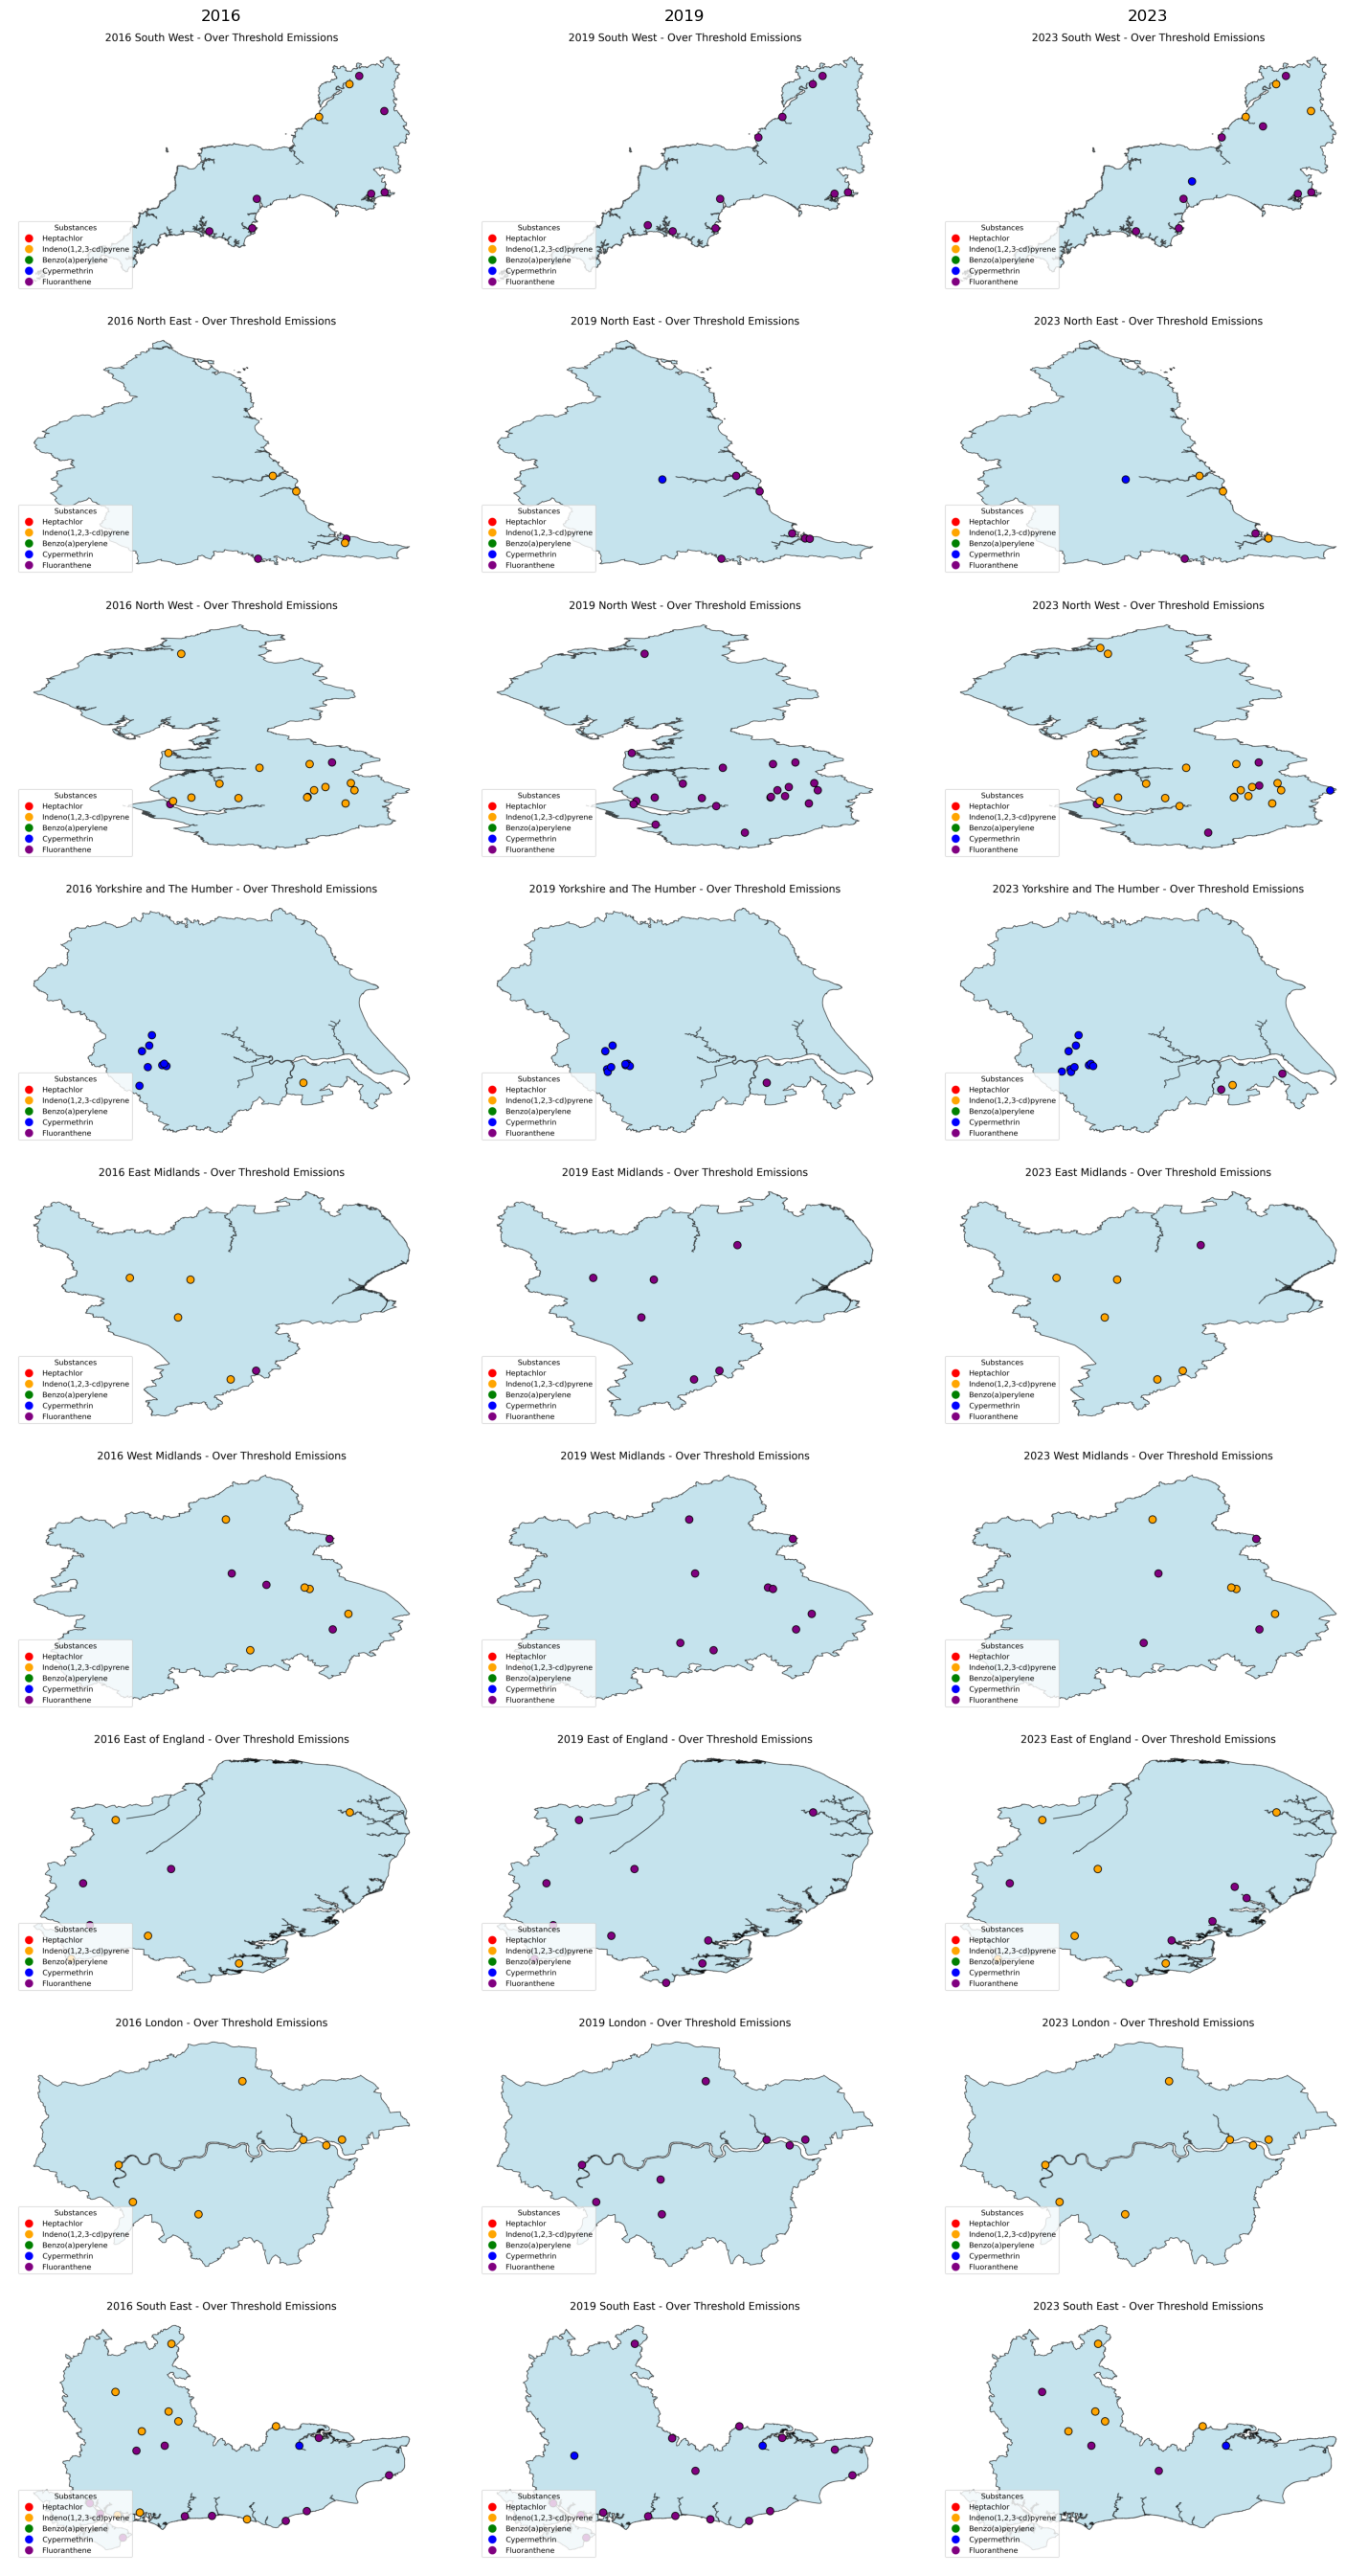

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

regions = [
    "South West",
    "North East",
    "North West",
    "Yorkshire and The Humber",
    "East Midlands",
    "West Midlands",
    "East of England",
    "London",
    "South East"
]

years = [2016, 2019, 2023]

fig, axes = plt.subplots(len(regions), len(years), figsize=(15, 3 * len(regions)))

for i, region in enumerate(regions):
    for j, year in enumerate(years):
        ax = axes[i, j] if len(regions) > 1 else axes[j]  
        safe_region = region.replace(" ", "_").replace("&", "and")
        img_path = f"{year}_{safe_region}_emissions_map.png"

        if os.path.exists(img_path):
            img = mpimg.imread(img_path)
            ax.imshow(img)
            ax.axis("off")
            if i == 0:
                ax.set_title(str(year), fontsize=12)
            if j == 0:
                ax.set_ylabel(region, fontsize=12)
        else:
            ax.text(0.5, 0.5, "Image not found", ha='center', va='center', fontsize=10)
            ax.axis("off")

plt.tight_layout()
plt.show()


### Summary for companies 

In [19]:
def summarize_emissions_and_operators(csv_file, year, region_name):
    selected_region = next(
        (f for f in geojson_data["features"] if f["properties"].get("RGN24NM") == region_name), None
    )
    if not selected_region:
        print(f" Region '{region_name}' not found in GeoJSON")
        return None

    geom = shape(selected_region["geometry"])
    df = pd.read_csv(csv_file)
    df.columns = df.columns.str.strip()
    df["SUBSTANCE NAME"] = df["SUBSTANCE NAME"].str.strip()

    df = df[
        df["SUBSTANCE NAME"].isin(target_substances) &
        df["Latitude"].notna() &
        df["Longitude"].notna() &
        df["REPORTING THRESHOLD (kg)"].notna() &
        df["QUANTITY RELEASED (kg)"].notna() &
        df["OPERATOR NAME"].notna()
    ].copy()

    def is_valid_point(row):
        try:
            qty = float(row["QUANTITY RELEASED (kg)"])
            threshold = float(row["REPORTING THRESHOLD (kg)"])
            point = Point(float(row["Longitude"]), float(row["Latitude"]))
            return qty > threshold and geom.contains(point)
        except:
            return False

    df_filtered = df[df.apply(is_valid_point, axis=1)]

    # Group statistics: The number of unique companies with total emissions
    summary = df_filtered.groupby("SUBSTANCE NAME").agg(
        **{
            "Total Emission (kg)": pd.NamedAgg(column="QUANTITY RELEASED (kg)", aggfunc="sum"),
            "Unique Operators": pd.NamedAgg(column="OPERATOR NAME", aggfunc="nunique"),
        }
    ).reset_index()

    summary["Year"] = year
    summary["Region"] = region_name

    return summary


In [21]:
# Save all the results
all_stats = []

for year, csv_file in csv_by_year.items():
    for region in regions_to_plot:
        result = summarize_emissions_and_operators(csv_file, year, region)
        if result is not None:
            all_stats.append(result)

# Merge
if all_stats:
    final_df = pd.concat(all_stats, ignore_index=True)
    final_df = final_df[["Year", "Region", "SUBSTANCE NAME", "Total Emission (kg)", "Unique Operators"]]
    final_df = final_df.sort_values(by=["Year", "Region", "SUBSTANCE NAME"])

    final_df.to_excel("emission_and_operator_summary.xlsx", index=False)
    print("✅ Saved：emission_and_operator_summary.xlsx")
else:
    print(" No data found")


✅ Saved：emission_and_operator_summary.xlsx


In [23]:
final_df.to_excel("emission_and_operator_summary.xlsx", index=False)

In [25]:

# Read the statistical results
summary_df = pd.read_excel("emission_and_operator_summary.xlsx")

summary_df 


,Year,Region,SUBSTANCE NAME,Total Emission (kg),Unique Operators
0,2016,East Midlands,Fluoranthene,1.6900,2
1,2016,East Midlands,"Indeno(1,2,3-cd)pyrene",8.9300,2
2,2016,East of England,Fluoranthene,1.7700,2
3,2016,East of England,"Indeno(1,2,3-cd)pyrene",7.8200,2
4,2016,London,Fluoranthene,9.0200,1
...,...,...,...,...,...
58,2023,West Midlands,Fluoranthene,3.4400,1
59,2023,West Midlands,"Indeno(1,2,3-cd)pyrene",16.2700,1
60,2023,Yorkshire and The Humber,Cypermethrin,12.2712,9
61,2023,Yorkshire and The Humber,Fluoranthene,2.9600,3


### Maps for companies (full version)

In [31]:
from shapely.geometry import shape, Point

output_dir = "region_company_year_maps"
os.makedirs(output_dir, exist_ok=True)

substance_colors = {
    "Heptachlor": "red",
    "Indeno(1,2,3-cd)pyrene": "blue",
    "Benzo(a)perylene": "green",
    "Cypermethrin": "orange",
    "Fluoroanthene": "purple",
}

# Traverse each year
for year, csv_file in csv_by_year.items():
    if year not in [2016, 2019, 2023]:
        continue

    df = pd.read_csv(csv_file)
    df.columns = df.columns.str.strip()
    df["SUBSTANCE NAME"] = df["SUBSTANCE NAME"].str.strip()

    # Filter out the substances we are concerned about, 
    # as well as the effective location and threshold data
    df = df[
        df["SUBSTANCE NAME"].isin(target_substances) &
        df["Latitude"].notna() &
        df["Longitude"].notna() &
        df["REPORTING THRESHOLD (kg)"].notna() &
        df["QUANTITY RELEASED (kg)"].notna() &
        df["OPERATOR NAME"].notna()
    ].copy()

    for region_name in regions_to_plot:
        selected_region = next(
            (f for f in geojson_data["features"] if f["properties"].get("RGN24NM") == region_name), None
        )
        if not selected_region:
            print(f" Region not found: {region_name}")
            continue

        geom = shape(selected_region["geometry"])

        # Check whether the company is within the area or exceeds the threshold
        def valid_operator_row(row):
            try:
                qty = float(row["QUANTITY RELEASED (kg)"])
                threshold = float(row["REPORTING THRESHOLD (kg)"])
                point = Point(float(row["Longitude"]), float(row["Latitude"]))
                return qty > threshold and geom.contains(point)
            except:
                return False

        df_filtered = df[df.apply(valid_operator_row, axis=1)].copy()

        if df_filtered.empty:
            print(f"❌ No data for {year} - {region_name}")
            continue

        # De-duplication company: 
        #When a company handles multiple substances, it merges them
df_filtered["Longitude"] = df_filtered["Longitude"].astype(float)
df_filtered["Latitude"] = df_filtered["Latitude"].astype(float)

# Aggregation company → Summarize the types of substances
df_grouped = (
    df_filtered.groupby(["OPERATOR NAME", "Latitude", "Longitude"])
    .agg({"SUBSTANCE NAME": lambda x: ", ".join(sorted(set(x)))})
    .reset_index()
)

fig, ax = plt.subplots(figsize=(8, 6))

if geom.geom_type == "Polygon":
    x, y = geom.exterior.xy
    ax.fill(x, y, color="lightgray", edgecolor="black", alpha=0.5)
elif geom.geom_type == "MultiPolygon":
    for polygon in geom.geoms:
        x, y = polygon.exterior.xy
        ax.fill(x, y, color="lightgray", edgecolor="black", alpha=0.5)

# Mark and annotate each company
for _, row in df_grouped.iterrows():
    lat, lon = row["Latitude"], row["Longitude"]
    operator = row["OPERATOR NAME"]
    substances = row["SUBSTANCE NAME"]
    
    ax.scatter(lon, lat, color="black", s=60, alpha=0.7, zorder=2)
    ax.text(
        lon,
        lat,
        f"{operator} ({substances})",
        fontsize=6.5,
        ha="left",
        va="bottom",
        zorder=3,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.6, pad=1),
    )

ax.set_title(f"{region_name} - {year}", fontsize=12)
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

filename = f"{year}_{region_name.replace(' ', '_')}_map_with_labels.png"
filepath = os.path.join(output_dir, filename)
plt.savefig(filepath, dpi=300, bbox_inches="tight")
plt.close()
print(f"✅ Saved with labels: {filepath}")


✅ Saved with labels: region_company_year_maps/2023_South_East_map_with_labels.png
